In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from sklearn.metrics import cohen_kappa_score, f1_score

# Uploading data

## Human annotators

r/t - reddit/twitter

bs/fs/ir/wl - annotator initials

cc/ai - climate change/artificial intelligence


Annotator 1

In [ ]:
r_bs_cc = pd.read_excel('/content/drive/MyDrive/MA thesis/2nd round/Reddit_r2_a1_zgodność_climate.xlsx')
r_bs_ai = pd.read_excel('/content/drive/MyDrive/MA thesis/2nd round/Reddit_r2_a1_zgodność_AI.xlsx')

t_bs_cc = pd.read_excel('/content/drive/MyDrive/MA thesis/2nd round/Twitter_r2_a1_zgodność_climate.xlsx')
t_bs_ai = pd.read_excel('/content/drive/MyDrive/MA thesis/2nd round/Twitter_r2_a1_zgodność_AI.xlsx')

Annotator 2

In [ ]:
r_fs_cc = pd.read_excel('/content/drive/MyDrive/MA thesis/2nd round/Reddit_r2_a2_zgodność_climate.xlsx')
r_fs_ai = pd.read_excel('/content/drive/MyDrive/MA thesis/2nd round/Reddit_r2_a2_zgodność_AI.xlsx')

t_fs_cc = pd.read_excel('/content/drive/MyDrive/MA thesis/2nd round/Twitter_r2_a2_zgodność_climate.xlsx')
t_fs_ai = pd.read_excel('/content/drive/MyDrive/MA thesis/2nd round/Twitter_r2_a2_zgodność_AI.xlsx')

Annotator 3

In [ ]:
r_ir_cc = pd.read_excel('/content/drive/MyDrive/MA thesis/2nd round/Reddit_r2_a3_zgodność_climate_corrected.xlsx')
r_ir_ai = pd.read_excel('/content/drive/MyDrive/MA thesis/2nd round/Reddit_r2_a3_zgodność_AI.xlsx')

t_ir_cc = pd.read_excel('/content/drive/MyDrive/MA thesis/2nd round/Twitter_r2_a3_zgodność_climate.xlsx')
t_ir_ai = pd.read_excel('/content/drive/MyDrive/MA thesis/2nd round/Twitter_r2_a3_zgodność_AI.xlsx')

Annotator 4

In [ ]:
r_wl_cc = pd.read_excel('/content/drive/MyDrive/MA thesis/2nd round/Reddit_r2_a4_zgodność_climate.xlsx')
r_wl_ai = pd.read_excel('/content/drive/MyDrive/MA thesis/2nd round/Reddit_r2_a4_zgodność_AI.xlsx')

t_wl_cc = pd.read_excel('/content/drive/MyDrive/MA thesis/2nd round/Twitter_r2_a4_zgodność_climate.xlsx')
t_wl_ai = pd.read_excel('/content/drive/MyDrive/MA thesis/2nd round/Twitter_r2_a4_zgodność_AI.xlsx')

## Saving files - automatic annotation

### Transforming dictonaries to columns

In [ ]:
file_paths = {
    "r_gpt_cc": '/content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki do zgodności/Reddit_climate_with_no_bias_output.xlsx',
    "r_gpt_ai": '/content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki do zgodności/Reddit_AI_with_no_bias_output.xlsx',
    "t_gpt_cc": '/content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki do zgodności/Twitter_climate_with_no_bias_output.xlsx',
    "t_gpt_ai": '/content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki do zgodności/Twitter_AI_with_no_bias_output.xlsx'
}

def clean_bias_column(bias_string):
    try:
        return ast.literal_eval(f"{{{bias_string.strip('.,')}}}")
    except (SyntaxError, ValueError):
        return {}

for name, path in file_paths.items():
    df = pd.read_excel(path)

     if 'bias' in df.columns:
        df['cleaned_bias'] = df['bias'].dropna().apply(clean_bias_column)
        bias_df = pd.DataFrame(df['cleaned_bias'].tolist(), index=df.index).fillna(0)
        processed_df = pd.concat([df.drop(columns=['bias', 'cleaned_bias']), bias_df], axis=1)

        output_path = path.replace(".xlsx", "_processed.xlsx")
        processed_df.to_excel(output_path, index=False)
        print(f"Processed data saved for {name} to {output_path}")
    else:
        print(f"No 'bias' column found in {name}, skipping.")

Processed data saved for r_gpt_cc to /content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki do zgodności/Reddit_climate_with_no_bias_output_processed.xlsx
Processed data saved for r_gpt_ai to /content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki do zgodności/Reddit_AI_with_no_bias_output_processed.xlsx
Processed data saved for t_gpt_cc to /content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki do zgodności/Twitter_climate_with_no_bias_output_processed.xlsx
Processed data saved for t_gpt_ai to /content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki do zgodności/Twitter_AI_with_no_bias_output_processed.xlsx


### Transforming probabilities to labels

In [ ]:
r_gpt_cc = pd.read_excel('/content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki po anotacji/Reddit_climate_with_no_bias_output_processed.xlsx')
r_gpt_ai =pd.read_excel('/content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki po anotacji/Reddit_AI_with_no_bias_output_processed.xlsx')

t_gpt_cc = pd.read_excel('/content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki po anotacji/Twitter_climate_with_no_bias_output_processed.xlsx')
t_gpt_ai = pd.read_excel('/content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki po anotacji/Twitter_AI_with_no_bias_output_processed.xlsx')

In [ ]:
bias_columns = ['affect_h', 'availability_h', 'representativeness_h', 'confirmation_b', 'all_or_nothing']

In [ ]:
bias_columns_no_bias = ['affect_h', 'availability_h', 'representativeness_h', 'confirmation_b', 'all_or_nothing', 'no_bias']

In [ ]:
# Select columns representing biases including 'unclear'
bias_columns_with_unclear = ['affect_h', 'availability_h', 'representativeness_h',
                             'confirmation_b', 'all_or_nothing', 'no_bias', 'unclear']

In [ ]:
def annotate_biases(df, bias_columns, threshold=0.1):
    """
    Annotate the biases based on probabilities.

    Parameters:
    - df: DataFrame containing the data.
    - bias_columns: List of columns representing bias probabilities.
    - threshold: The percentage difference within which other biases are marked (default 10%).

    Returns:
    - A DataFrame with binary annotations for biases.
    """
    annotated_df = df.copy()

    for index, row in df.iterrows():
        max_prob = row[bias_columns].max()

        threshold_value = max_prob * (1 - threshold)

        for col in bias_columns:
            if row[col] >= threshold_value:
                annotated_df.at[index, col] = 1
            else:
                annotated_df.at[index, col] = None
    return annotated_df

annotated_df = annotate_biases(t_gpt_ai, bias_columns_no_bias)
annotated_df.to_excel('/content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki po anotacji/Twitter_AI_with_no_bias_labels.xlsx', index=False)

In [ ]:
# Update the process function to consistently include "unclear"
def process_and_label_biases_updated(df):
    """
    Process the DataFrame to include bias columns.

    Parameters:
    - df: DataFrame containing the raw bias data.

    Returns:
    - A DataFrame with bias columns extracted.
    """
    if 'bias' in df.columns:
        df['cleaned_bias'] = df['bias'].dropna().apply(clean_bias_column)
        bias_df = pd.DataFrame(df['cleaned_bias'].tolist(), index=df.index).fillna(0)
        if 'unclear' not in bias_df.columns:
            bias_df['unclear'] = 0
        processed_df = pd.concat([df.drop(columns=['bias', 'cleaned_bias']), bias_df], axis=1)
        return processed_df
    else:
        print("No 'bias' column found, returning original DataFrame.")
        return df


processed_with_labels_updated_df = process_and_label_biases_updated(df)
annotated_with_unclear_updated_df = annotate_biases_with_unclear(processed_with_labels_updated_df, bias_columns_with_unclear)

In [ ]:
annotated_df.describe()

,affect_h,availability_h,representativeness_h,confirmation_b,all_or_nothing,no_bias
count,33.0,4.0,67.0,62.0,146.0,79.0
mean,1.0,1.0,1.0,1.0,1.0,1.0
std,0.0,0.0,0.0,0.0,0.0,0.0
min,1.0,1.0,1.0,1.0,1.0,1.0
25%,1.0,1.0,1.0,1.0,1.0,1.0
50%,1.0,1.0,1.0,1.0,1.0,1.0
75%,1.0,1.0,1.0,1.0,1.0,1.0
max,1.0,1.0,1.0,1.0,1.0,1.0


### Uploading files with labels (1/0) from probabilities

In [ ]:
r_gpt_cc = pd.read_excel('/content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki po anotacji/Reddit_climate_with_no_bias_labels.xlsx')
r_gpt_ai = pd.read_excel('/content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki po anotacji/Reddit_AI_with_no_bias_labels.xlsx')

t_gpt_cc = pd.read_excel('/content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki po anotacji/Twitter_climate_with_no_bias_labels.xlsx')
t_gpt_ai = pd.read_excel('/content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki po anotacji/Twitter_AI_with_no_bias_labels.xlsx')

### Merging into 1 file

In [ ]:
gpt_files = [
    '/content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki po anotacji/Reddit_climate_with_no_bias_labels.xlsx',
    '/content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki po anotacji/Reddit_AI_with_no_bias_labels.xlsx',
    '/content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki po anotacji/Twitter_climate_with_no_bias_labels.xlsx',
    '/content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki po anotacji/Twitter_AI_with_no_bias_labels.xlsx'
]

gpt_dfs = [pd.read_excel(file) for file in gpt_files]
merged_gpt_df = pd.concat(gpt_dfs, ignore_index=True)

merged_gpt_df.to_excel('/content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki po anotacji/full_GPT_4o_labels.xlsx', index=False)

# Adding 'unclear' label


## Function to establish "unclear"

### Merging 4 "processed" files with probabilities

In [ ]:
gpt_files = [
    '/content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki po anotacji/Reddit_climate_with_no_bias_output_processed.xlsx',
    '/content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki po anotacji/Reddit_AI_with_no_bias_output_processed.xlsx',
    '/content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki po anotacji/Twitter_climate_with_no_bias_output_processed.xlsx',
    '/content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki po anotacji/Twitter_AI_with_no_bias_output_processed.xlsx'
]

gpt_dfs = [pd.read_excel(file) for file in gpt_files]
processed_merged_gpt_df = pd.concat(gpt_dfs, ignore_index=True)

In [ ]:
processed_merged_gpt_df.to_excel('/content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki po anotacji/merged_processed_gpt.xlsx', index=False)

In [ ]:
processed_merged_gpt_df = pd.read_excel('/content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki po anotacji/Pliki  - prawdopodobieństwa w kolumnach/merged_processed_gpt.xlsx')

In [ ]:
processed_merged_gpt_df

,title,post_id_x,comment_id,comment_author,Text,affect_h,availability_h,representativeness_h,confirmation_b,all_or_nothing,no_bias,Conversation ID,Tweet ID,Author ID,Created At,probability_range
0,"premium gas, better for the environment?",1aup2v9,NaN,NaN,"premium gas, better for the environment? in on...",0.15,0.20,0.10,0.25,0.05,0.25,NaN,NaN,NaN,NaN,0.20
1,NaN,1aup2v9,kr58z1h,BigMax,It makes no difference. It's simply a slightl...,0.10,0.15,0.05,0.20,0.40,0.10,NaN,NaN,NaN,NaN,0.35
2,NaN,1aup2v9,kr5apkg,yonasismad,Reduce the amount of animal products you consume.,0.10,0.10,0.10,0.10,0.10,0.50,NaN,NaN,NaN,NaN,0.40
3,NaN,1aup2v9,kr56eqf,Sorryallthetime,Why would you think burning premium gas would ...,0.10,0.15,0.05,0.20,0.30,0.20,NaN,NaN,NaN,NaN,0.25
4,NaN,1aup2v9,kr59ksx,squamishter,Unless your engine is knocking on lower grades...,0.10,0.15,0.05,0.20,0.30,0.20,NaN,NaN,NaN,NaN,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994,NaN,NaN,NaN,NaN,@EdwardChaber @pepedownunder @JmelzMD ??? \nTh...,0.15,0.30,0.10,0.60,0.40,0.05,'1764804529655001537,'1765030939464212598,'2784441757,2024-03-05 15:05:43,0.55
2995,NaN,NaN,NaN,NaN,@Shpeko08 @pepedownunder @JmelzMD ..which is e...,0.25,0.15,0.30,0.20,0.60,0.05,'1764804529655001537,'1765030525226340724,'1265598300,2024-03-05 15:04:04,0.55
2996,NaN,NaN,NaN,NaN,@EdwardChaber @pepedownunder @JmelzMD And how ...,0.40,0.10,0.05,0.05,0.30,0.10,'1764804529655001537,'1765030183604539427,'2784441757,2024-03-05 15:02:43,0.35
2997,NaN,NaN,NaN,NaN,@EdwardChaber @pepedownunder @JmelzMD And the ...,0.10,0.20,0.15,0.40,0.30,0.05,'1764804529655001537,'1765030122598330672,'2784441757,2024-03-05 15:02:28,0.35


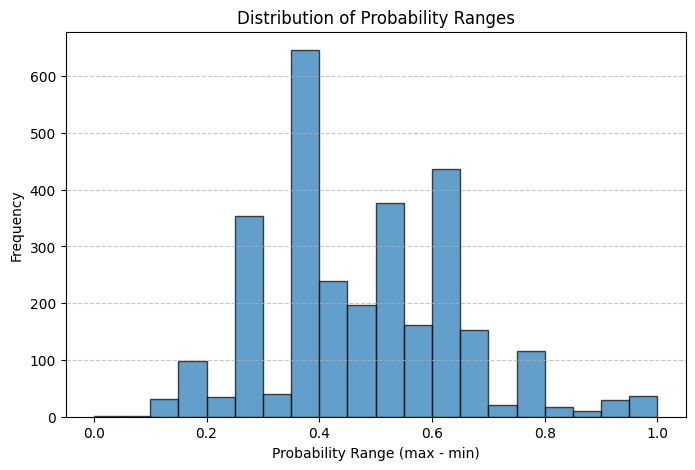

,probability_range
count,2999.000000
mean,0.475405
std,0.180879
min,0.000000
25%,0.350000
50%,0.450000
75%,0.650000
max,1.000000


In [ ]:
# Calculate the range (max - min) of probabilities for each row
probability_columns = ['affect_h', 'availability_h', 'representativeness_h',
                       'confirmation_b', 'all_or_nothing', 'no_bias']
processed_merged_gpt_df['probability_range'] = processed_merged_gpt_df[probability_columns].max(axis=1) - processed_merged_gpt_df[probability_columns].min(axis=1)
range_stats = processed_merged_gpt_df['probability_range'].describe()

plt.figure(figsize=(8, 5))
plt.hist(processed_merged_gpt_df['probability_range'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Probability Ranges')
plt.xlabel('Probability Range (max - min)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

range_stats

In [ ]:
processed_merged_gpt_df[probability_columns] = (
    processed_merged_gpt_df[probability_columns]
    .apply(pd.to_numeric, errors='coerce')
)

# probability_range  (max – min across the six bias columns)
processed_merged_gpt_df['probability_range'] = (
    processed_merged_gpt_df[probability_columns].max(axis=1)
    - processed_merged_gpt_df[probability_columns].min(axis=1)
)

# row_probability_std  (standard deviation across the six bias columns)
processed_merged_gpt_df['row_probability_std'] = (
    processed_merged_gpt_df[probability_columns].std(axis=1)
)

# 25-th percentile of probability_range
p25_range = processed_merged_gpt_df['probability_range'].quantile(0.25)

# Subset of “tight” rows (range below 25-th percentile)
tight_subset = processed_merged_gpt_df[
    processed_merged_gpt_df['probability_range'] < p25_range
]

# Means on that subset → dynamic thresholds
mean_std   = tight_subset['row_probability_std'].mean()
mean_range = tight_subset['probability_range'].mean()

print(f"25th-percentile range : {p25_range:.4f}")
print(f"Mean std (subset)    : {mean_std:.4f}")
print(f"Mean range (subset)  : {mean_range:.4f}")

# Refined unclear flag using the dynamic thresholds
processed_merged_gpt_df['unclear'] = (
    (processed_merged_gpt_df['row_probability_std'] < mean_std) &
    (processed_merged_gpt_df['probability_range']   < mean_range)
).astype(int)              # 1 = unclear, 0 = clear

processed_merged_gpt_df[['probability_range',
                               'row_probability_std',
                               'unclear']].describe()

25th-percentile range : 0.3500
Mean std (subset)    : 0.0930
Mean range (subset)  : 0.2400


,probability_range,row_probability_std,unclear
count,2999.000000,2999.000000,2999.000000
mean,0.475405,0.184959,0.048016
std,0.180879,0.074803,0.213836
min,0.000000,0.000000,0.000000
25%,0.350000,0.125167,0.000000
50%,0.450000,0.169558,0.000000
75%,0.650000,0.240139,0.000000
max,1.000000,0.408248,1.000000


## Labeling as unclear
Criterias:
- row_probability_std <0,093
- probability_range < 0.2


In [ ]:
bias_columns = ['affect_h', 'availability_h', 'representativeness_h',
                'confirmation_b', 'all_or_nothing', 'no_bias']

# Calculate `probability_range` and `row_probability_std`
processed_merged_gpt_df['probability_range'] = (
    processed_merged_gpt_df[bias_columns].max(axis=1) - processed_merged_gpt_df[bias_columns].min(axis=1)
)
processed_merged_gpt_df['row_probability_std'] = processed_merged_gpt_df[bias_columns].std(axis=1)

# Apply the refined criteria for "unclear"
processed_merged_gpt_df['unclear'] = (
    (processed_merged_gpt_df['row_probability_std'] < 0.093) &
    (processed_merged_gpt_df['probability_range'] < 0.2)
).astype(int)

###Updated annotate_biases function

In [ ]:
def annotate_biases(df, bias_columns, threshold=0.1, unclear_column='unclear'):
    """
    Annotate the biases based on probabilities, excluding rows marked as 'unclear'.

    Parameters:
    - df: DataFrame containing the data.
    - bias_columns: List of columns representing bias probabilities.
    - threshold: The percentage difference within which other biases are marked (default 10%).
    - unclear_column: Name of the column indicating unclear rows (default 'unclear').

    Returns:
    - A DataFrame with binary annotations for biases.
    """
    annotated_df = df.copy()

    for index, row in df.iterrows():
        if unclear_column in df.columns and row[unclear_column] == 1:
            continue

        max_prob = row[bias_columns].max()
        threshold_value = max_prob * (1 - threshold)

        for col in bias_columns:
            if row[col] >= threshold_value:
                annotated_df.at[index, col] = 1
            else:
                annotated_df.at[index, col] = None

    return annotated_df

In [ ]:
processed_merged_gpt_df

,title,post_id_x,comment_id,comment_author,Text,affect_h,availability_h,representativeness_h,confirmation_b,all_or_nothing,no_bias,Conversation ID,Tweet ID,Author ID,Created At,probability_range,row_probability_std,unclear
0,"premium gas, better for the environment?",1aup2v9,NaN,NaN,"premium gas, better for the environment? in on...",0.15,0.20,0.10,0.25,0.05,0.25,NaN,NaN,NaN,NaN,0.20,0.081650,0
1,NaN,1aup2v9,kr58z1h,BigMax,It makes no difference. It's simply a slightl...,0.10,0.15,0.05,0.20,0.40,0.10,NaN,NaN,NaN,NaN,0.35,0.125167,0
2,NaN,1aup2v9,kr5apkg,yonasismad,Reduce the amount of animal products you consume.,0.10,0.10,0.10,0.10,0.10,0.50,NaN,NaN,NaN,NaN,0.40,0.163299,0
3,NaN,1aup2v9,kr56eqf,Sorryallthetime,Why would you think burning premium gas would ...,0.10,0.15,0.05,0.20,0.30,0.20,NaN,NaN,NaN,NaN,0.25,0.087560,0
4,NaN,1aup2v9,kr59ksx,squamishter,Unless your engine is knocking on lower grades...,0.10,0.15,0.05,0.20,0.30,0.20,NaN,NaN,NaN,NaN,0.25,0.087560,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994,NaN,NaN,NaN,NaN,@EdwardChaber @pepedownunder @JmelzMD ??? \nTh...,0.15,0.30,0.10,0.60,0.40,0.05,'1764804529655001537,'1765030939464212598,'2784441757,2024-03-05 15:05:43,0.55,0.208966,0
2995,NaN,NaN,NaN,NaN,@Shpeko08 @pepedownunder @JmelzMD ..which is e...,0.25,0.15,0.30,0.20,0.60,0.05,'1764804529655001537,'1765030525226340724,'1265598300,2024-03-05 15:04:04,0.55,0.188193,0
2996,NaN,NaN,NaN,NaN,@EdwardChaber @pepedownunder @JmelzMD And how ...,0.40,0.10,0.05,0.05,0.30,0.10,'1764804529655001537,'1765030183604539427,'2784441757,2024-03-05 15:02:43,0.35,0.147196,0
2997,NaN,NaN,NaN,NaN,@EdwardChaber @pepedownunder @JmelzMD And the ...,0.10,0.20,0.15,0.40,0.30,0.05,'1764804529655001537,'1765030122598330672,'2784441757,2024-03-05 15:02:28,0.35,0.130384,0


In [ ]:
annotated_df = annotate_biases(processed_merged_gpt_df, bias_columns, threshold=0.1, unclear_column='unclear')

In [ ]:
annotated_df.to_excel('/content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki po anotacji/merged_annotated_gpt.xlsx', index=False)

# Descriptive statistics

## Imports & upload

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/MA thesis/Open AI automatic annotation/Pliki po anotacji/merged_annotated_gpt_platform_topic.xlsx')

In [ ]:
id_vars = [
    'title',
    'post_id_x',
    'comment_id',
    'comment_author',
    'text',
    'Conversation ID',
    'Tweet ID',
    'Author ID',
    'Created At',
    'probability_range',
    'row_probability_std',
    'unclear',
    'platform',
    'topic'
]

bias_cols = [
    'affect_h',
    'availability_h',
    'representativeness_h',
    'confirmation_b',
    'all_or_nothing',
    'no_bias'
]

df_long = df.melt(
    id_vars=id_vars,
    value_vars=bias_cols,
    var_name='bias_type',
    value_name='flag'
)

flagged = df_long[(df_long['flag'] == 1) & (df_long['unclear'] == False)]
unclear = (
    df[df['unclear'] == True]
    .loc[:, ['platform', 'topic']]
    .assign(bias_type='Unclear')
)
annots = pd.concat([
    flagged[['platform', 'topic', 'bias_type']],
    unclear[['platform', 'topic', 'bias_type']]
], ignore_index=True)

full_names = {
    "affect_h": "Affect heuristic",
    "availability_h": "Availability heuristic",
    "representativeness_h": "Representativeness heuristic",
    "confirmation_b": "Confirmation bias",
    "all_or_nothing": "All-or-nothing thinking",
    "no_bias": "No bias",
    "Unclear": "Unclear"
}
order = [
    "Affect heuristic",
    "Availability heuristic",
    "Representativeness heuristic",
    "Confirmation bias",
    "All-or-nothing thinking",
    "No bias",
    "Unclear"
]

annots['bias_full'] = annots['bias_type'].map(full_names)

## Tables

In [ ]:
# a) Counts per bias_full × PLATFORM
platform_stats = (
    annots.groupby(['bias_full', 'platform'])
           .size()
           .reset_index(name='count')
)
platform_stats['bias_full'] = pd.Categorical(platform_stats['bias_full'], categories=order, ordered=True)
platform_pivot = (
    platform_stats
    .pivot(index='bias_full', columns='platform', values='count')
    .fillna(0)
    .astype(int)
)
print("\n=== Counts per Bias by PLATFORM ===")
print(platform_pivot)

# b) Counts per bias_full × TOPIC
topic_stats = (
    annots.groupby(['bias_full', 'topic'])
           .size()
           .reset_index(name='count')
)
topic_stats['bias_full'] = pd.Categorical(topic_stats['bias_full'], categories=order, ordered=True)
topic_pivot = (
    topic_stats
    .pivot(index='bias_full', columns='topic', values='count')
    .fillna(0)
    .astype(int)
)
print("\n=== Counts per Bias by TOPIC ===")
print(topic_pivot)


=== Counts per Bias by PLATFORM ===
platform                      Reddit  Twitter
bias_full                                    
Affect heuristic                 246       93
Availability heuristic           158       28
Representativeness heuristic      89       82
Confirmation bias                323      122
All-or-nothing thinking          724      357
No bias                          624      163
Unclear                           97       28

=== Counts per Bias by TOPIC ===
topic                          AI  climate
bias_full                                 
Affect heuristic              176      163
Availability heuristic         50      136
Representativeness heuristic  126       45
Confirmation bias             170      275
All-or-nothing thinking       535      546
No bias                       398      389
Unclear                        66       59


In [ ]:
# Overall distribution: count and percentage
total_items = df.shape[0]
overall_stats = (
    annots.groupby('bias_full')
    .size()
    .reset_index(name='count')
)
overall_stats['percent'] = (overall_stats['count'] / total_items) * 100
overall_stats = overall_stats.set_index('bias_full').loc[order].reset_index()

print("\n=== Overall distribution ===")
print(overall_stats)

# 7. Counts & % per Bias by Platform
# a) counts
platform_stats = (
    annots.groupby(['bias_full', 'platform'])
           .size()
           .reset_index(name='count')
)
platform_stats['bias_full'] = pd.Categorical(platform_stats['bias_full'], categories=order, ordered=True)

# b) platform totals from original df
platform_totals = df['platform'].value_counts()

# c) compute percentage
platform_stats['percent'] = platform_stats.apply(
    lambda row: (row['count'] / platform_totals[row['platform']]) * 100,
    axis=1
)

# d) pivot for display
platform_pivot = platform_stats.pivot(
    index='bias_full', columns='platform', values=['count', 'percent']
)

platform_pivot.columns = [
    f"{col[1]}_{col[0]}" for col in platform_pivot.columns
]

print("\n=== Counts per Bias by PLATFORM ===")
print(platform_pivot)


=== Overall distribution ===
                      bias_full  count    percent
0              Affect heuristic    339  11.303768
1        Availability heuristic    186   6.202067
2  Representativeness heuristic    171   5.701901
3             Confirmation bias    445  14.838279
4       All-or-nothing thinking   1081  36.045348
5                       No bias    787  26.242081
6                       Unclear    125   4.168056

=== Counts per Bias by PLATFORM ===
                              Reddit_count  Twitter_count  Reddit_percent  \
bias_full                                                                   
Affect heuristic                     246.0           93.0       11.263736   
Availability heuristic               158.0           28.0        7.234432   
Representativeness heuristic          89.0           82.0        4.075092   
Confirmation bias                    323.0          122.0       14.789377   
All-or-nothing thinking              724.0          357.0       33.1501

## Graphs

In [ ]:
# Bar-charts
sns.set_theme(style="whitegrid")
figsize = (12, 6)
cmap_full = cm.get_cmap("Blues")
palette_light = [tuple(c[:3]) for c in (cmap_full(0.25), cmap_full(0.60))]

<ipython-input-12-eccbf8d88d22>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_full = cm.get_cmap("Blues")


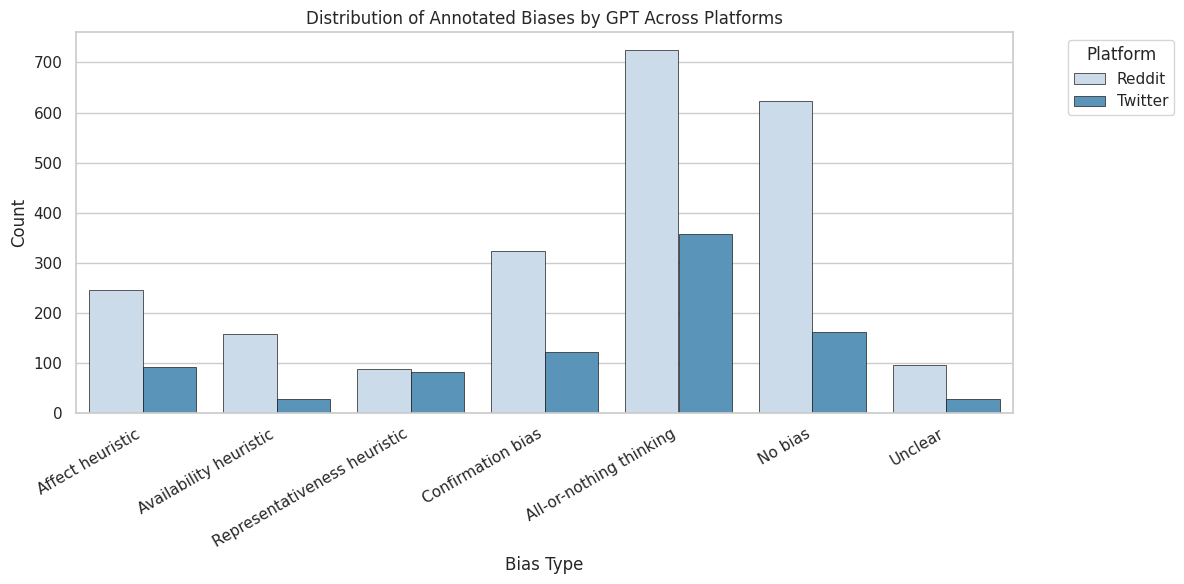

In [ ]:
# Plot: Distribution by PLATFORM
plt.figure(figsize=figsize)
sns.barplot(
    data=platform_stats,
    x="bias_full", y="count", hue="platform",
    order=order,
    palette=palette_light,
    edgecolor="0.1", linewidth=0.5
)
plt.xlabel("Bias Type")
plt.ylabel("Count")
plt.title("Distribution of Annotated Biases by GPT Across Platforms")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Platform", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

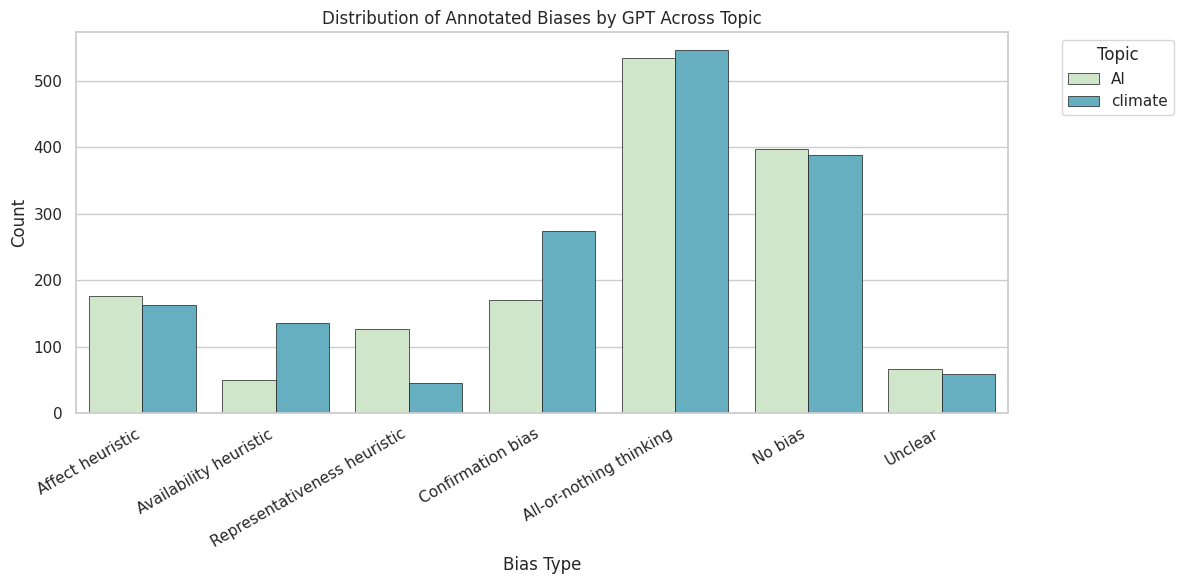

In [ ]:
# Plot: Distribution by TOPIC
plt.figure(figsize=figsize)
sns.barplot(
    data=topic_stats,
    x="bias_full", y="count", hue="topic",
    order=order,
    palette=palette_light,
    edgecolor="0.1", linewidth=0.5
)
plt.xlabel("Bias Type")
plt.ylabel("Count")
plt.title("Distribution of Annotated Biases by GPT Across Topic")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()